In [35]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
import pandas as pd
import numpy as np

from tqdm import tqdm
from PIL import Image

In [37]:
from game_assets.utils import simplify_image, save_img
from conv_rgb.model import ConvRGB

In [38]:
from pysimulacra.data import SimulacraData

ds = SimulacraData('../raw_data/sac_public_2022_06_29.sqlite')

# data = ds.fetch_all_data()

In [39]:
'raw_data/sac-000000'

'raw_data/sac-000000'

In [40]:
# 'simulacra-aesthetic-captions'

In [41]:
# img_df = ds.get_image_paths_and_prompts()

In [42]:
img_df = ds.get_image_paths_and_prompts_and_ratings()
img_df

,img_id,img_prompt,img_path,img_rating
0,1,An artwork of a broken wine bottle in the medi...,0_An_artwork_of_a_broken_wine_bottle_in_the_me...,7
1,1,An artwork of a broken wine bottle in the medi...,0_An_artwork_of_a_broken_wine_bottle_in_the_me...,1
2,6,An artwork of a broken wine bottle in the medi...,0_An_artwork_of_a_broken_wine_bottle_in_the_me...,4
3,5,An artwork of a broken wine bottle in the medi...,0_An_artwork_of_a_broken_wine_bottle_in_the_me...,6
4,4,An artwork of a broken wine bottle in the medi...,0_An_artwork_of_a_broken_wine_bottle_in_the_me...,6
...,...,...,...,...
176934,248438,beautiful portrait of a smiling flame witch ho...,43043_beautiful_portrait_of_a_smiling_flame_wi...,5
176935,248439,beautiful portrait of a smiling flame witch ho...,43043_beautiful_portrait_of_a_smiling_flame_wi...,7
176936,248440,beautiful portrait of a smiling flame witch ho...,43043_beautiful_portrait_of_a_smiling_flame_wi...,6
176937,248441,avatar of a dragon knight anato finnstark yosi...,43044_avatar_of_a_dragon_knight_anato_finnstar...,5


In [67]:
def square_image(pil_img):
    
    width, height = pil_img.size # Get dimensions
    
    if width < height:
        new_width, new_height = width, width
    else:
        new_width, new_height = height, height
        
    left = (width - new_width)/2
    top = (height - new_height)/2
    right = (width + new_width)/2
    bottom = (height + new_height)/2

    # Crop the center of the image
    im = pil_img.crop((left, top, right, bottom))
    
    return im

In [68]:
def simplify_image(pil_img, num_colors = 8, size = (256, 256)):

    img = pil_img.quantize(colors=num_colors, method=2)
    
    sq_img = square_image(img).resize(size, Image.LANCZOS)
    
    return sq_img

def add_border(old_img, width = 6):
    img_arr = np.array(old_img)

    old_size = old_img.size
    
    new_size = [size + width for size in old_size]

    new_img = Image.new("RGB", new_size, 'White')
    box = tuple((n - o) // 2 for n, o in zip(new_size, old_size))
    new_img.paste(old_img, box)
    
    return new_img

In [43]:
def shorten_path(img_path):
    name_parts = img_path.split('_')
    new_name = f'{name_parts[0]}_{name_parts[-1]}'
    return new_name

In [44]:
img_df['short_img_path'] = img_df.img_path.apply(shorten_path)

In [45]:
import regex as re
import string

def clean_png_path(file_name):
    
    file_name = file_name.replace(',', ' ')
    
    #suffix = file_name[-4:]
    
    clean_file_name = re.sub(r'[^A-Za-z0-9 ]+', '', file_name)
    
#     if clean_file_name == "":
#         clean_file_name
    
    return '_'.join(clean_file_name.split()) # + suffix


In [46]:
img_df['clean_prompt'] = img_df.img_prompt.apply(clean_png_path)

In [47]:
# https://github.com/google-research-datasets/conceptual-captions/blob/master/LICENSE
# https://ai.google.com/research/ConceptualCaptions/download

# data = pd.read_csv('../raw_data/Validation_GCC-1.1.0-Validation.tsv', sep = '\t', header = None)
# data.columns = ['caption', 'url']

In [48]:
import torch
import clip

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-L/14", device=device) # "ViT-B/32"


def clip_encode_image(pil_img):
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    image = preprocess(pil_img).unsqueeze(0).to(device)

    with torch.no_grad():
        image_features = model.encode_image(image)

    return image_features


In [619]:
colour_model = ConvRGB(input_shape = (240, 240), n_cut = 8)

In [632]:
import matplotlib.pyplot as plt

def colours_as_pct(input_images):
#     print(np.min(input_images))
    images = np.add(np.ones(input_images.shape), input_images)
#   images = images + 1 # avoid dividing by zero
#     if np.min(images) == '0':
#     print('min:',  np.min(images))
#     print(type(images))
#     print(images)
#     plt.imshow(images[0] / 255)
#     plt.show()
        
#     images = np.true_divide(images, images.sum(axis=-1, keepdims=True))
    
    images = images / images.sum(axis=-1, keepdims=True)
    return images

In [633]:
def colour_encode_image(pil_img):
    
    img = pil_img.resize((240, 240))
    
    X = np.expand_dims(np.array(img), axis = 0)
    
    X = colours_as_pct(X)
    
    colour_features = colour_model(X)
    
    return colour_features

In [1161]:
img_array_list = [np.array(Image.open(f'../raw_data/sac_images2/{image_path}')) for image_path in image_path_list]

In [ ]:
# def get_common_colors():




In [1226]:
all_na = np.array(img_array_list)

all_colours, all_counts = np.unique(all_na.reshape(-1,3), axis=0, return_counts=1) 

In [1227]:
len(colours), len(counts)

(147372, 147372)

In [1228]:
counts

array([ 407055,     244,      12, ...,       2,       1, 3939520])

In [1229]:
threshold = sorted(counts)[-256]

In [1230]:
64**0.5

8.0

In [1231]:
col_palette = (colours[counts >= threshold] * 255).astype(np.uint8).reshape((16, 16, 3))

In [1232]:
col_palette.size

768

In [1234]:
np.arange(0, 255, 10)

array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
       130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250])

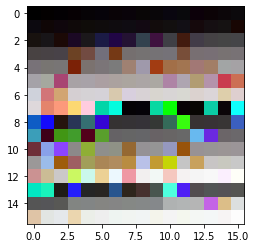

In [1377]:
plt.imshow(col_palette) 

In [1198]:
Image.fromarray(col_palette)

In [1438]:
from itertools import product

def gen_color_palette(init_size):
    
    values = np.linspace(0, 255, init_size).astype(np.uint8)

    rgb_pal = np.array(list(product(values, repeat=3)))
    
    return rgb_pal

In [1352]:
!mkdir ../results/

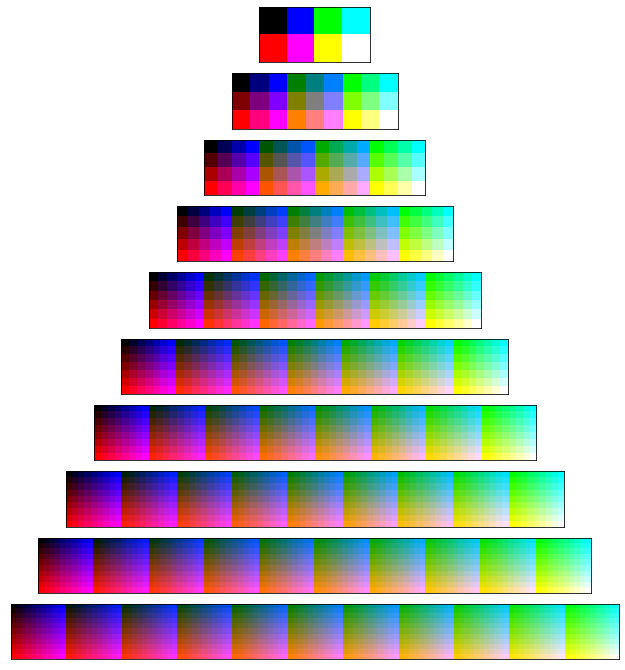

In [1363]:
fig, axes = plt.subplots(10, 1, figsize = (12, 12))

for i, ax in enumerate(axes.flat):
    rgb_pal = gen_color_palette(i + 2)
    ax.imshow(rgb_pal.reshape(i + 2, -1, 3))
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.savefig('../results/color_stack.png', facecolor = 'white')

In [677]:
os.listdir('../raw_data/sac-000000/')

['25308_2.png',
 '13941_1.png',
 '26058_1.png',
 '38376_1.png',
 '1280_4.png',
 '16742_2.png',
 '7322_7.png',
 '10188_1.png',
 '13474_3.png',
 '8254_4.png',
 '15654_6.png',
 '8440_5.png',
 '16996_5.png',
 '7278_5.png',
 '31379_2.png',
 '5478_7.png',
 '9110_4.png',
 '5732_8.png',
 '31472_1.png',
 '42288_1.png',
 '20593_2.png',
 '1063_6.png',
 '17664_4.png',
 '41840_4.png',
 '18791_1.png',
 '5147_8.png',
 '33932_1.png',
 '16508_8.png',
 '3151_3.png',
 '30198_2.png',
 '36326_4.png',
 '18636_3.png',
 '16371_5.png',
 '23585_3.png',
 '38647_1.png',
 '32540_4.png',
 '27630_4.png',
 '37416_1.png',
 '19900_6.png',
 '9093_7.png',
 '28033_2.png',
 '26668_1.png',
 '6980_7.png',
 '12380_2.png',
 '10434_8.png',
 '22808_1.png',
 '11427_2.png',
 '36358_2.png',
 '38687_1.png',
 '13963_6.png',
 '8661_5.png',
 '5954_4.png',
 '409_4.png',
 '23870_1.png',
 '6509_4.png',
 '37792_1.png',
 '6650_1.png',
 '5275_7.png',
 '27165_4.png',
 '32215_4.png',
 '35419_1.png',
 '8434_8.png',
 '18002_7.png',
 '5662_1.png'

In [832]:
def qcolour_encode_image(pil_img):
    
    q_img = pil_img.quantize(colors=256, method=2)
    
    features = np.unique(np.array(p_img), return_counts = True)[1]
    
    return features
    

In [935]:
def qcolour_encode_image(pil_img):
    
    p_img = pil_img.convert('P', palette=1)

#     plt.imshow(p_img)
#     plt.show()

    colcounts = np.unique(np.array(p_img), return_counts = True)

#     print(colcounts)

    features = np.zeros((256))

    for i in range(len(colcounts[0])):

        idx = colcounts[0][i]

        count = colcounts[1][i]

        features[idx] = count
        
    return features

In [ ]:
# https://stackoverflow.com/questions/17728757/do-all-8-bit-colors-exist-in-24-bit-color-space-if-so-how-to-map

In [1203]:
col_palette_long * 1.5

array([  0. ,   0. ,   0. ,   1.5,   0. ,   0. ,   3. ,   0. ,   1.5,
         3. ,   1.5,   3. ,   3. ,   1.5,   4.5,   4.5,   3. ,   3. ,
         6. ,   1.5,   3. ,   7.5,   3. ,   6. ,  13.5,   4.5,  18. ,
        25.5,  33. ,  39. ,  31.5,   9. ,  31.5,  34.5,  33. ,  34.5,
        34.5,  34.5,  36. ,  36. ,  33. ,  34.5,  58.5,  57. ,  58.5,
        60. ,  57. ,  58.5,  82.5,  81. ,  82.5,  82.5,  84. ,  79.5,
        84. ,  81. ,  82.5,  85.5,  82.5,  82.5,  87. ,  66. ,  82.5,
       106.5, 105. , 106.5, 108. , 105. , 106.5, 108. , 106.5, 106.5,
       109.5, 105. , 103.5, 130.5, 129. , 130.5, 132. , 129. , 130.5,
       133.5, 130.5, 132. , 156. , 153. , 153. , 156. , 153. , 154.5,
       157.5, 175.5, 223.5, 159. ,   0. ,  12. , 160.5,  78. , 150. ,
       172.5,  79.5, 150. , 178.5, 178.5, 178.5, 180. , 177. , 178.5,
       180. , 180. , 180. , 181.5, 178.5, 180. , 202.5, 202.5, 202.5,
       205.5, 204. , 204. , 208.5, 207. , 172.5, 226.5, 226.5, 226.5,
       228. , 226.5,

In [1210]:
256 / 192

1.3333333333333333

In [1208]:
4 * 64

256

In [1368]:
len(col_palette_long)

192

In [1371]:
4 ** 3 * 3

192

In [1413]:
len(col_palette_long) / 3

64.0

In [1400]:
len(col_palette_long) * 3 / 256

7.59375

In [1403]:
64 * 4

256

In [1396]:
6 ** 3 * 3 / 256

2.53125

In [1398]:
16 * 16

256

In [1422]:
print('colors:', 4 ** 3)
print('pal_length:', 4 ** 3)

colors: 64


In [1423]:
8 ** 2

64

array([[  0,   0,   0],
       [  0,   0,  85],
       [  0,   0, 170],
       [  0,   0, 255],
       [  0,  85,   0],
       [  0,  85,  85],
       [  0,  85, 170],
       [  0,  85, 255],
       [  0, 170,   0],
       [  0, 170,  85],
       [  0, 170, 170],
       [  0, 170, 255],
       [  0, 255,   0],
       [  0, 255,  85],
       [  0, 255, 170],
       [  0, 255, 255],
       [ 85,   0,   0],
       [ 85,   0,  85],
       [ 85,   0, 170],
       [ 85,   0, 255],
       [ 85,  85,   0],
       [ 85,  85,  85],
       [ 85,  85, 170],
       [ 85,  85, 255],
       [ 85, 170,   0],
       [ 85, 170,  85],
       [ 85, 170, 170],
       [ 85, 170, 255],
       [ 85, 255,   0],
       [ 85, 255,  85],
       [ 85, 255, 170],
       [ 85, 255, 255],
       [170,   0,   0],
       [170,   0,  85],
       [170,   0, 170],
       [170,   0, 255],
       [170,  85,   0],
       [170,  85,  85],
       [170,  85, 170],
       [170,  85, 255],
       [170, 170,   0],
       [170, 170

In [1597]:


def qcolour_encode_image(pil_img):
    
    # could maybe increase colour features ?

    colour_palette  = gen_color_palette(4)

    colour_palette_long = colour_palette.reshape(-1)

    pal_img = Image.new('P', (16, 16))
    pal_img.putpalette(list(colour_palette_long) * 4)

    q_img = pil_img.resize((64, 64)).quantize(palette=pal_img, dither=0, method=2)
    
#     q_img.save('temp.png')
    
#     open_img = Image.fromarray((plt.imread('temp.png')[:, :, :3] * 255).astype(np.uint8)).convert('RGB')
    
#     print('open:', open_img.mode)
    
    new_rgb_img = Image.new('RGB', (64, 64), 0xFF)
    new_rgb_img.paste(q_img)
    
#     print(new_rgb_img.mode)
    
#     print(open_img.mode)
    
    # Convert Image to RGB and make into Numpy array
    rgb_img = np.array(new_rgb_img) 
    
#     print(rgb_img.shape)
        
    plt.imshow(rgb_img)
    
#     print(rgb_img.reshape((-1,3)).shape)

    # Get used colours and counts of each
    colours, counts = np.unique(rgb_img.reshape((-1,3)), axis=0, return_counts=1)
    
#     print(len(colours))
#     print(len(counts))

    colour_counter = {k.tobytes(): 0 for k in colour_palette}
    
#     print(len(colour_counter))

    for i in range(len(colours)):

        idx = colours[i].tobytes()

        count = counts[i]

        colour_counter[idx] = count
        
#     print(len(colour_counter))

    features = np.array(list(colour_counter.values()))
#     if len(features) != 64:
#         print(len(features))

    return features



array([ 71, 199, 263,   0,   0,  15,  41,   0,   0,   0,   0,   0,   0,
         0,   0,   0, 157,  25,   0,   0, 127, 901,  93,   0,   0,  61,
        28,   1,   0,   0,   0,   0, 183,  16,   0,   0,  26, 120,  27,
         0,   0, 131, 964,  55,   0,   0,   3,   2, 160,   0,   0,   0,
         0,  34,  12,   0,   0,  26,  75,  14,   0,   0,   5, 261])

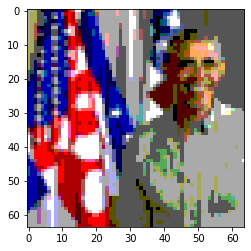

In [1601]:
timg = Image.open('../raw_data/sac-000000/11394_2.png')
qcolour_encode_image(timg)

In [1441]:
gen_color_palette(4)

array([[  0,   0,   0],
       [  0,   0,  85],
       [  0,   0, 170],
       [  0,   0, 255],
       [  0,  85,   0],
       [  0,  85,  85],
       [  0,  85, 170],
       [  0,  85, 255],
       [  0, 170,   0],
       [  0, 170,  85],
       [  0, 170, 170],
       [  0, 170, 255],
       [  0, 255,   0],
       [  0, 255,  85],
       [  0, 255, 170],
       [  0, 255, 255],
       [ 85,   0,   0],
       [ 85,   0,  85],
       [ 85,   0, 170],
       [ 85,   0, 255],
       [ 85,  85,   0],
       [ 85,  85,  85],
       [ 85,  85, 170],
       [ 85,  85, 255],
       [ 85, 170,   0],
       [ 85, 170,  85],
       [ 85, 170, 170],
       [ 85, 170, 255],
       [ 85, 255,   0],
       [ 85, 255,  85],
       [ 85, 255, 170],
       [ 85, 255, 255],
       [170,   0,   0],
       [170,   0,  85],
       [170,   0, 170],
       [170,   0, 255],
       [170,  85,   0],
       [170,  85,  85],
       [170,  85, 170],
       [170,  85, 255],
       [170, 170,   0],
       [170, 170

In [1416]:
pal_img

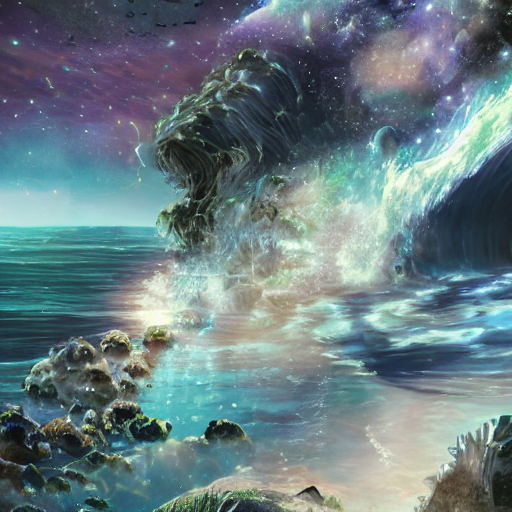

In [1433]:
timg

In [1431]:
Image.fromarray(gen_color_palette(4))

In [1131]:
Image.fromarray(col_palette).convert('P')

In [ ]:
palette = [
    159, 4, 22,
    98, 190, 48,
    122, 130, 188,
    67, 153, 0,
]

p_img = Image.new('P', (16, 16))
p_img.putpalette(palette * 64)


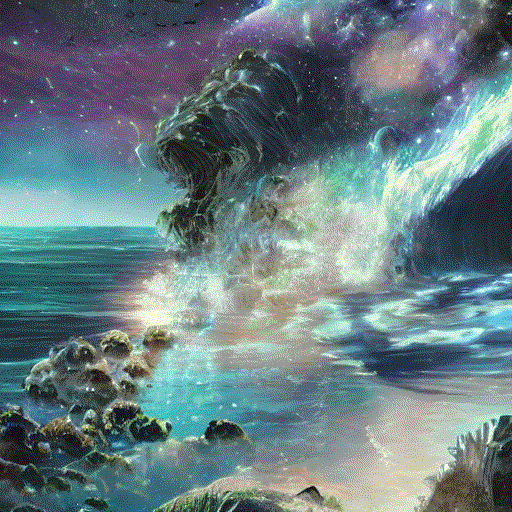

In [1152]:
timg = Image.open('../raw_data/sac-000000/19885_3.png') #  

q_img = timg.quantize(palette = Image.fromarray(col_palette).convert('P'), method=2)
    

# p_img = timg.convert('P', palette=1, colors = 8)

# p_img

# q_img = p_img.convert('RGB')

q_img

In [1418]:
pal_img = Image.new('P', (16, 16))
pal_img

In [1134]:
# Convert Image to RGB and make into Numpy array
na = np.array(q_img.convert('RGB')) 

# Get used colours and counts of each
colours, counts = np.unique(na.reshape((-1,3)), axis=0, return_counts=1) 

len(colours)

92

In [939]:
timg = Image.open('../raw_data/sac-000000/5954_4.png') #  6650_1

# q_img = timg.quantize(colors=8, method=2)
    
# q_img = q_img.convert('RGB')
p_img = timg.convert('P', palette=1)

#     plt.imshow(p_img)
#     plt.show()

colcounts = np.unique(np.array(p_img), return_counts = True)

#     print(colcounts)

features = np.zeros((256))

for i in range(len(colcounts[0])):

    idx = colcounts[0][i]

    count = colcounts[1][i]

    features[idx] = count
    
features

array([104.,  38., 311., 367., 662., 274.,  77.,  19., 561., 200., 230.,
       378., 204., 264., 123., 255., 677., 314., 239., 274., 282., 116.,
       346., 157., 297., 325., 258., 243., 232., 169., 227., 359., 323.,
       206., 297., 279., 192., 321., 333., 250., 375., 316., 271., 206.,
       246., 263., 236., 146., 252., 210., 514., 284., 197., 171., 276.,
       212., 401., 100., 473.,  92., 213., 274., 406., 164., 102., 428.,
       322., 246., 239., 247., 247., 123., 331., 199., 240.,  56., 213.,
       354., 562., 336., 167., 229., 204., 522., 203., 241., 251., 127.,
       223., 396., 297., 406., 290., 149., 226., 111., 321., 175.,  71.,
       426., 281., 404., 280., 278.,  97., 334., 327., 212., 297., 253.,
       151., 176., 278., 336., 177.,  65., 332., 179., 240., 233., 189.,
       346., 493., 404., 150., 512., 141., 243., 293., 300., 171., 159.,
       238., 361., 275.,  68., 174., 216., 146., 268., 252., 154., 275.,
       399., 482., 290., 115., 393., 311., 189.,  6

In [940]:
colcounts

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

In [881]:
palette = np.array(p_img.getpalette(),dtype=np.uint8).reshape((256,3))
palette

array([[  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [ 51,   0,   0],
       [102,   0,   0],
       [153,   0,   0],
       [204,   0,   0],
       [255,   0,   0],
       [  0,  51,   0],
       [ 51,  51,   0],
       [102,  51,   0],
       [153,  51,   0],
       [204,  51,   0],
       [255,  51,   0],
       [  0, 102,   0],
       [ 51, 102,   0],
       [102, 102,   0],
       [153, 102,   0],
       [204, 102,   0],
       [255, 102,   0],
       [  0, 153,   0],
       [ 51, 153,   0],
       [102, 153,   0],
       [153, 153,   0],
       [204, 153,   0],
       [255, 153,   0],
       [  0, 204,   0],
       [ 51, 204,   0],
       [102, 204,   0],
       [153, 204,   0],
       [204, 204,   0],
       [255, 204,   0],
       [  0, 255,   0],
       [ 51, 255

In [890]:
len(colours)

44561

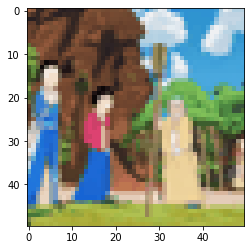

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 1

In [906]:
# q_img = timg.quantize(colors = 4, method=2)

# plt.imshow(q_img)
# plt.show()

# #q_img = q_img.convert('RGB')

# plt.imshow(q_img)
# plt.show()

# # colcounts = np.unique(np.array(q_img), return_counts = True)

# # print(colcounts)

timg = Image.open('../raw_data/sac-000000/35355_1.png').resize((50, 50))


p_img = timg.convert('P', palette=1, colours = 32)

plt.imshow(p_img)
plt.show()

colcounts = np.unique(np.array(p_img), return_counts = True)

print(colcounts)

features = np.zeros((256))

for i in range(len(colcounts[0])):

    idx = colcounts[0][i]

    count = colcounts[1][i]

    features[idx] = count

In [904]:
features

array([104.,  38., 311., 367., 662., 274.,  77.,  19., 561., 200., 230.,
       378., 204., 264., 123., 255., 677., 314., 239., 274., 282., 116.,
       346., 157., 297., 325., 258., 243., 232., 169., 227., 359., 323.,
       206., 297., 279., 192., 321., 333., 250., 375., 316., 271., 206.,
       246., 263., 236., 146., 252., 210., 514., 284., 197., 171., 276.,
       212., 401., 100., 473.,  92., 213., 274., 406., 164., 102., 428.,
       322., 246., 239., 247., 247., 123., 331., 199., 240.,  56., 213.,
       354., 562., 336., 167., 229., 204., 522., 203., 241., 251., 127.,
       223., 396., 297., 406., 290., 149., 226., 111., 321., 175.,  71.,
       426., 281., 404., 280., 278.,  97., 334., 327., 212., 297., 253.,
       151., 176., 278., 336., 177.,  65., 332., 179., 240., 233., 189.,
       346., 493., 404., 150., 512., 141., 243., 293., 300., 171., 159.,
       238., 361., 275.,  68., 174., 216., 146., 268., 252., 154., 275.,
       399., 482., 290., 115., 393., 311., 189.,  6

In [808]:
len(colcounts[0])

57

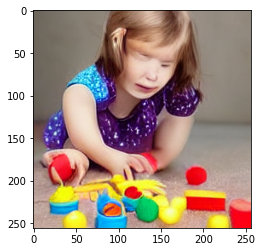

In [914]:
plt.imshow(timg)

In [915]:
qcolour_encode_image(timg)

array([104.,  38., 311., 367., 662., 274.,  77.,  19., 561., 200., 230.,
       378., 204., 264., 123., 255., 677., 314., 239., 274., 282., 116.,
       346., 157., 297., 325., 258., 243., 232., 169., 227., 359., 323.,
       206., 297., 279., 192., 321., 333., 250., 375., 316., 271., 206.,
       246., 263., 236., 146., 252., 210., 514., 284., 197., 171., 276.,
       212., 401., 100., 473.,  92., 213., 274., 406., 164., 102., 428.,
       322., 246., 239., 247., 247., 123., 331., 199., 240.,  56., 213.,
       354., 562., 336., 167., 229., 204., 522., 203., 241., 251., 127.,
       223., 396., 297., 406., 290., 149., 226., 111., 321., 175.,  71.,
       426., 281., 404., 280., 278.,  97., 334., 327., 212., 297., 253.,
       151., 176., 278., 336., 177.,  65., 332., 179., 240., 233., 189.,
       346., 493., 404., 150., 512., 141., 243., 293., 300., 171., 159.,
       238., 361., 275.,  68., 174., 216., 146., 268., 252., 154., 275.,
       399., 482., 290., 115., 393., 311., 189.,  6

In [776]:
import os
all_imgs = os.listdir('../raw_data/sac-000000/')

In [777]:
exist_df = pd.DataFrame({'short_img_path': pd.Series(all_imgs)})

In [636]:
len(pd.Series(all_imgs)), len(pd.Series(all_imgs).unique())

(2259, 2259)

In [637]:
df = exist_df.merge(img_df, how = 'inner').drop_duplicates()

In [638]:
df_loop = df.sort_values('img_rating', ascending = False)[:1000]

In [639]:
# df_loop

In [640]:
!mkdir ../raw_data/sac_images2

mkdir: ../raw_data/sac_images2: File exists


1000it [00:21, 46.80it/s]


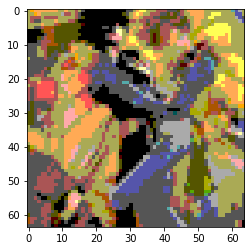

In [1602]:
#clip_features_list = []
colour_features_list = []
#image_path_list = []

for i, row in tqdm(df_loop.iterrows()):
    
    img_path, caption = row['short_img_path'], row['clean_prompt']
    
    if img_path.endswith('png'):

        img = Image.open(f'../raw_data/sac-000000/{img_path}')

        if img:
            
            #img = colours_as_pct(img)

            #clip_features_list.append(clip_encode_image(img)[0])
            #colour_features_list.append(colour_encode_image(img)[0])
            colour_features_list.append(qcolour_encode_image(img))
            
            
            #simple_img = simplify_image(img, num_colors = 256)
            
            #simple_img = add_border(simple_img, width = 8)

            #save_img(simple_img, caption, destination_folder = '../raw_data/sac_images3')

            #image_path_list.append(f"{caption}.png")
#     if len(features_list) % 10 == 0:
#         print(len(features_list))
        
        

#image = get_simplified_image(url, caption, destination_folder = '../raw_data/images', num_colors = 256)

In [ ]:
colour_features_list

In [1603]:
image_embeddings = np.stack(clip_features_list)
colour_embeddings = np.stack(colour_features_list)


In [1604]:
image_embeddings[:947].shape

(947, 768)

In [1605]:
colour_embeddings[:947].shape

(947, 64)

In [846]:
# the embeddings and img list are not the same length because of the loop failure point
# need to drop one extra img/embed

In [1618]:
colour_embeddings

array([[243,   0,   0, ...,   0,   0,   0],
       [416,  15,   0, ...,   0,  23,  73],
       [  9,   0,   0, ...,   0,  71,   5],
       ...,
       [361, 223,   0, ...,   4,   0,   0],
       [176,  98,   0, ...,   2,  29,   1],
       [401,   0,   0, ...,  79,   8,   0]])

In [1619]:
log_col_emb = np.ma.log(colour_embeddings[:947]).filled(0)



(array([817.,  21.,  23.,   9.,  16.,  13.,  17.,  20.,   9.,   2.]),
 array([0.        , 0.6499787 , 1.29995741, 1.94993611, 2.59991482,
        3.24989352, 3.89987222, 4.54985093, 5.19982963, 5.84980834,
        6.49978704]),
 <BarContainer object of 10 artists>)

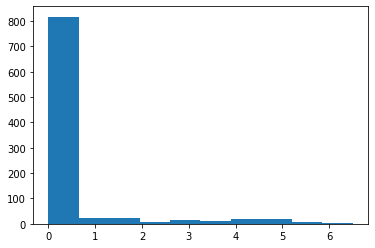

In [1620]:
plt.hist(log_col_emb[:, 10])

In [1632]:
common_colors = log_col_emb[:, log_col_emb.mean(axis = 0) > 1]

In [1633]:
from sklearn.preprocessing import StandardScaler

s_image_embeddings = StandardScaler().fit_transform(image_embeddings[:947])

s_colour_embeddings = StandardScaler().fit_transform(common_colors)

(array([115.,  19.,  38.,  40.,  84., 128., 189., 208., 106.,  20.]),
 array([-2.09443008, -1.71499361, -1.33555714, -0.95612067, -0.5766842 ,
        -0.19724774,  0.18218873,  0.5616252 ,  0.94106167,  1.32049814,
         1.6999346 ]),
 <BarContainer object of 10 artists>)

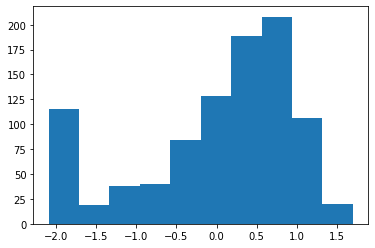

In [1634]:
plt.hist(s_colour_embeddings[:, 0])

(array([115.,  19.,  38.,  40.,  84., 128., 189., 208., 106.,  20.]),
 array([-2.09443008, -1.71499361, -1.33555714, -0.95612067, -0.5766842 ,
        -0.19724774,  0.18218873,  0.5616252 ,  0.94106167,  1.32049814,
         1.6999346 ]),
 <BarContainer object of 10 artists>)

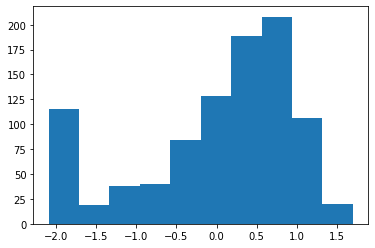

In [1609]:
plt.hist(s_colour_embeddings[:, 0])

In [192]:
np.stack([image_embeddings, colour_embeddings], axis = 0)

ValueError: all input arrays must have the same shape

In [1543]:
img_array_list = [np.array(Image.open(f'../raw_data/sac_images2/{image_path}'))/255 for image_path in image_path_list]

In [1544]:
len(img_array_list)

947

In [173]:
# X_image_embeddings = torch.from_numpy(image_embeddings)
# X_image_embeddings.shape

torch.Size([948, 768])

In [ ]:
colour_embeddings[:948]

In [174]:
# mnist = pymde.datasets.MNIST()
# mnist.data

In [1635]:
import pymde

image_mde = pymde.preserve_neighbors(s_image_embeddings, embedding_dim=2)
mde_image_2d = image_mde.embed()


colour_mde = pymde.preserve_neighbors(s_colour_embeddings, embedding_dim=2)
mde_colour_2d = colour_mde.embed()

Aug 21 10:44:25 PM: Your dataset appears to contain duplicated items (rows); when embedding, you should typically have unique items.
Aug 21 10:44:25 PM: The following items have duplicates [  5   7  18  28  33  37  55  69  76  81  91  94  95 100 107 126 129 165
 185 193 218 232 262 294 295 297 348 371 373 384 385 407 438 451 462 465
 470 483 488 519 526 534 544 568 581 604 640 663 665 687 690 703 709 751
 809 810 822 823 858 871 914 916 920 931 942]
Aug 21 10:44:26 PM: Your dataset appears to contain duplicated items (rows); when embedding, you should typically have unique items.
Aug 21 10:44:26 PM: The following items have duplicates [  4   5   7  28  33  44  47  56  71  81  87  91  95 100 117 118 121 124
 138 139 142 161 165 166 169 171 185 214 248 255 267 276 278 287 294 296
 297 307 311 317 336 348 374 381 400 409 425 460 462 464 467 482 483 485
 501 506 513 522 523 534 556 564 566 568 581 593 640 674 677 723 727 737
 739 749 755 781 794 797 799 810 819 839 858 862 914 920 937 942 

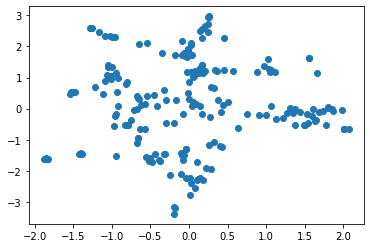

In [1581]:
import matplotlib.pyplot as plt
plt.scatter(mde_image_2d[-200:, 0], mde_image_2d[-200:, 1])

In [467]:
from umap import UMAP

umap_image_2d = UMAP().fit_transform(s_image_embeddings)
umap_colour_2d = UMAP().fit_transform(s_colour_embeddings)

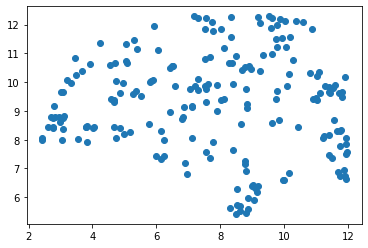

In [468]:
import matplotlib.pyplot as plt
plt.scatter(umap_colour_2d[-200:, 0], umap_colour_2d[-200:, 1])

In [267]:
np.isnan(s_colour_embeddings).sum()

0

In [568]:
# create and fit a 2d PCA
from sklearn.decomposition import PCA

pca = PCA(2)
pca.fit(s_image_embeddings)

pca.explained_variance_

# actually project only PC's
pca_image_2d = pca.transform(s_image_embeddings)

In [509]:
s_colour_embeddings.shape

(947, 1452)

In [1636]:
pca = PCA(2)
pca_colour_2d = pca.fit_transform(s_colour_embeddings)

# actually project only PC's
# pca.transform(mde_colour_2d)

In [925]:
pca.explained_variance_

array([116.87932022,   2.834069  ])

In [719]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from tensorflow.image import resize
from tqdm import tqdm
import numpy as np
from PIL import Image

def show_xy_images(x_coords, y_coords, img_arr_list, image_zoom=1):
    fig, ax = plt.subplots(1,1, figsize=(16, 16))
    artists = []
    for x_coord, y_coord, img in tqdm(zip(x_coords, y_coords, img_arr_list)):
        c_img = resize(img, [50,50])
        img = OffsetImage(c_img, zoom=image_zoom)
        ab = AnnotationBbox(img, (x_coord, y_coord),
                            xycoords='data',
                            frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.stack([x_coords, y_coords], axis=1))
    ax.autoscale()

In [562]:
pca_colour_2d

array([[ -2.836201  ,   0.31395307,  -1.027124  ,   0.77738744,
          0.16807874],
       [ -6.954053  ,   3.064603  ,  -1.0836805 ,  -3.1122801 ,
         -1.6192237 ],
       [  5.786526  ,  -8.071698  ,  -2.4053302 ,  -3.1687555 ,
         -2.6744366 ],
       ...,
       [ -3.5568185 , -13.727792  ,  -2.8936286 ,   0.6489706 ,
          2.8088913 ],
       [  3.7692275 ,  -3.5146117 ,   0.3397475 ,   1.2639722 ,
          1.9446558 ],
       [ 20.345531  , -17.561148  ,  -1.187094  ,   0.40142804,
          6.9195247 ]], dtype=float32)

In [ ]:
# including convert to pct is important
# include both?

In [555]:
len(pca_colour_2d), len(img_array_list)

(947, 947)

200it [00:00, 990.05it/s] 


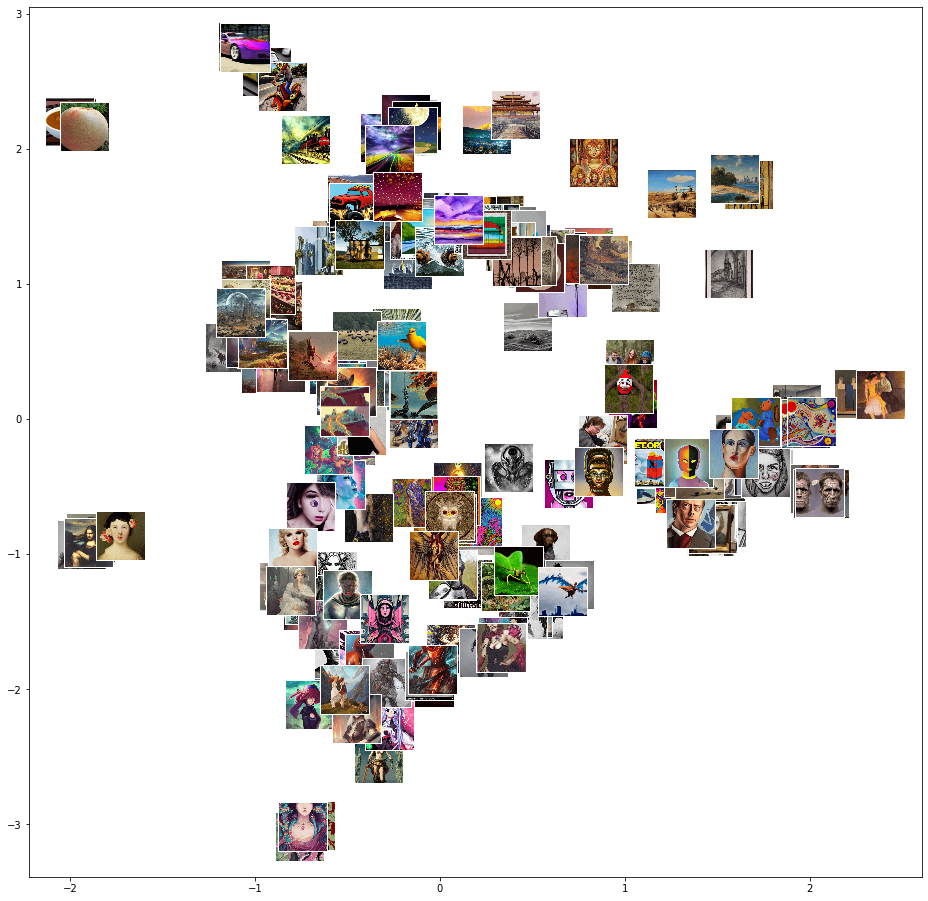

In [1612]:
show_xy_images(x_coords = mde_image_2d[-200:, 0], 
               y_coords = mde_image_2d[-200:, 1], 
               img_arr_list = img_array_list[-200:])


200it [00:00, 1063.28it/s]


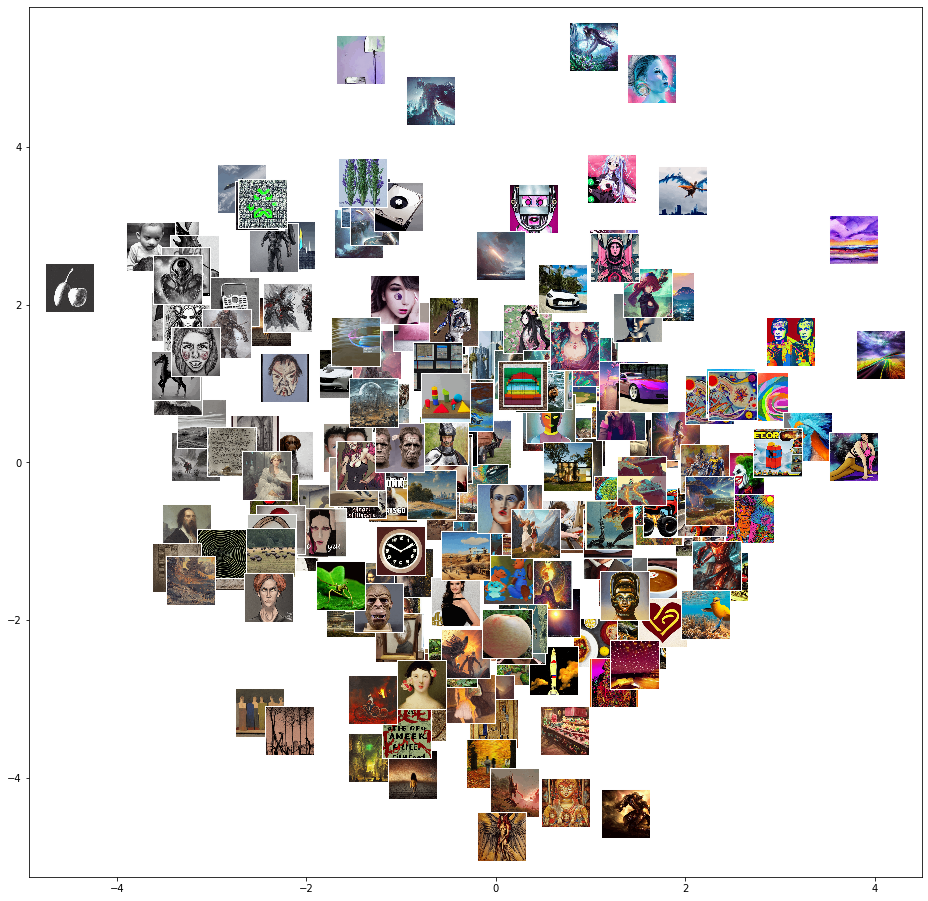

In [1638]:
# show_xy_images(x_coords = np.log(pca_colour_2d[-200:, 0] - min(pca_colour_2d[-200:, 0])), 
#                y_coords = pca_colour_2d[-200:, 1], 
#                img_arr_list = img_array_list[-200:])

show_xy_images(x_coords = pca_colour_2d[-200:, 0], 
               y_coords = pca_colour_2d[-200:, 1], 
               img_arr_list = img_array_list[-200:])

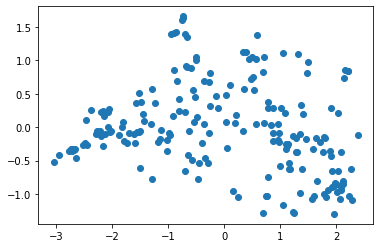

In [194]:
import matplotlib.pyplot as plt
plt.scatter(colour_2d[-200:, 0], colour_2d[-200:, 1])

In [195]:
# np.argwhere(embedding[:, 0] < -2)

In [196]:
# df_loop.iloc[[  9, 152, 207, 211, 342, 643], :]

In [201]:
!mkdir ../raw_data/sac_images_subset/

In [202]:
!ls ../raw_data

Validation_GCC-1.1.0-Validation.tsv latent_space_map.json
artist_images                       mj_background
artist_images_semisimple            mj_background.png
artist_images_simple                pad_background_100.png
images                              pad_background_100_256bit.png
images2                             sac-000000
images_simple                       sac_images
latent_space_background_256bit.png  sac_images_subset
latent_space_background_32bit.png   sac_public_2022_06_29.sqlite
latent_space_background_8bit.png


In [437]:
!mkdir ../raw_data/sac_images_subset2

In [438]:
import shutil

for path in image_path_list[-200:]:
    shutil.copy2(f'../raw_data/sac_images2/{path}', f'../raw_data/sac_images_subset2/{path}')

In [439]:
def embedding_to_coords(embedding, coord, scale = 1000):
    
    if coord == 'X':
        col = 0
    elif coord == 'Y':
        col = 1
    else:
        print("coord must be X or Y")
    
    coords = embedding.numpy()[:, col]
    
    print(coords)

    from_one = coords - min(coords)
    
    print(from_one)

    return [int(coord) for coord in (from_one / max(from_one) * scale)]

In [440]:
clean_png_path('author : a life in photography -- in pictures.png')

'author_a_life_in_photography_in_picturespng'

In [441]:
clean_image_path_list = [clean_png_path(path) for path in image_path_list]

In [213]:
embedding_to_coords(image_2d[-200:], 'X', scale = 1)

[ 0.6301441   0.36839834  1.8447255  -0.08925921  2.267181   -1.4735893
  0.33284163 -0.38114482  1.156299   -1.735236    1.8602356  -0.44984886
 -0.23178656 -0.89783674 -1.2211554  -1.5096049   0.06701159  2.1200945
 -0.2676938   0.25411943  0.607149    0.01104164 -0.26359898 -0.02182177
 -1.5083299   0.381817   -0.10824201  0.5413361   0.6135507  -0.8111511
 -0.41066974 -1.6682907   0.29719138 -0.90579623 -0.25047648 -0.18802346
  0.93212926 -0.09519415 -1.8427622   0.08513659 -0.02724191  0.7365371
  0.13840213 -1.5297585   1.1214162   0.9106823   1.7452544   0.27813894
 -0.28221816  0.621899    0.7862725  -1.4487085   1.030841   -0.8640677
  0.36993948 -1.4244267  -0.9146273  -0.31729805  0.8822071  -0.6819769
  0.36718476  0.9082412   0.5171608   0.3183227   0.66902256 -0.47737977
 -0.73971     0.21875836 -0.62259215 -0.7798246   1.1407903  -0.8125038
 -0.57473147 -1.7138908   0.74932885  0.2724867  -0.0943693   0.38478866
  0.92853916  0.8807121  -0.85664666  2.0512338   0.381873

[0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [442]:
# take 200 images with the highest rating
import json

X_image_coords = embedding_to_coords(mde_colour_2d[-200:], 'X', scale = 1000)
Y_image_coords = embedding_to_coords(mde_colour_2d[-200:], 'Y', scale = 1000)
X_colour_coords = embedding_to_coords(mde_colour_2d[-200:], 'X', scale = 1000)
Y_colour_coords = embedding_to_coords(mde_colour_2d[-200:], 'Y', scale = 1000)

map_json = {
    "X_image_coords": X_image_coords,
    "Y_image_coords": Y_image_coords,
    "X_colour_coords": X_colour_coords,
    "Y_colour_coords": Y_colour_coords,
    "image_paths": image_path_list[-200:]
}

with open('../raw_data/sac2_latent_space_map.json', 'w') as f:
    json.dump(map_json, f)


[ 0.68743026  2.7064683  -3.081813   -1.0904543   0.5710831  -0.11903058
  1.8028696   1.7718208  -1.1783092  -1.2252287  -2.7155046   2.4545631
  0.77503276  0.86383474  1.5890303  -1.9632629   1.5593814  -0.88548183
 -1.0511533  -2.4164078  -1.100153    1.9891427   1.7907712  -0.01889332
  1.8083799  -1.6843268   0.66792655  2.7155542   1.8735921   0.0107454
 -1.20233     0.67487544  0.48083693  1.8219982   0.645971    1.4740704
  1.9081781  -3.1090076  -1.8015195  -1.1978717   0.62558866 -2.0685208
 -1.8853871   0.39665657 -2.0020807   0.53800833 -1.9331704   1.4333328
  0.9321138  -2.7850385   2.4920619   3.0559323  -0.51582944 -2.4500678
 -0.32119012 -2.6075351   0.27498162  1.6079621   3.0150962  -0.09472415
 -0.5789019   3.0398498   0.80149955  0.6767649   2.8171678  -0.49634925
 -0.46952063  1.9932784   2.6695182  -0.51993734 -0.29900995 -1.4078058
 -0.48425442  1.9951668  -2.9238205  -2.8588054   0.772661    3.3250105
 -2.9110613  -2.9199438  -1.3824407  -3.0183425   0.0206206

In [443]:
map_json

{'X_image_coords': [599,
  906,
  27,
  329,
  582,
  477,
  768,
  764,
  316,
  309,
  83,
  867,
  612,
  626,
  736,
  197,
  732,
  360,
  335,
  128,
  328,
  797,
  767,
  492,
  769,
  239,
  596,
  907,
  779,
  497,
  312,
  597,
  568,
  771,
  593,
  719,
  784,
  23,
  221,
  313,
  590,
  181,
  209,
  555,
  191,
  577,
  201,
  712,
  636,
  72,
  873,
  959,
  417,
  123,
  446,
  99,
  537,
  739,
  952,
  480,
  407,
  956,
  617,
  598,
  922,
  420,
  424,
  797,
  900,
  416,
  449,
  281,
  421,
  798,
  51,
  61,
  612,
  1000,
  53,
  52,
  285,
  37,
  498,
  786,
  935,
  593,
  503,
  752,
  903,
  690,
  84,
  690,
  296,
  549,
  293,
  221,
  361,
  148,
  492,
  17,
  271,
  954,
  776,
  627,
  269,
  874,
  436,
  406,
  537,
  806,
  504,
  8,
  904,
  12,
  195,
  752,
  400,
  313,
  498,
  308,
  770,
  58,
  605,
  699,
  724,
  838,
  406,
  218,
  432,
  681,
  859,
  390,
  881,
  832,
  883,
  40,
  874,
  360,
  420,
  348,
  627,
  466,
  58

In [ ]:
# copy raw_data/sac_latent_space_map.json into the game assests folder

In [253]:
os.listdir('../raw_data/images')

['beverage_type_the_original_beer.png',
 'film_actor_attends_the_premiere_during_film_festival_and_festivals.png',
 'politicians_speaking_at_an_event.png',
 'man_carrying_pond_in_the_mountain.png',
 'leading_lady_actor_is_heading_up_the_cast_as_the_accused_woman_herself.png',
 'i_m_not_one_for_facial_piercings_but_i_must_say_that_fictional_character_can_be_really_beautiful.png',
 'fresh_green_forest_and_gentle_river_after_the_rain.png',
 'shoppers_struggle_through_the_heavy_snow.png',
 'person_feeding_apples_to_an_elephant_in_captivity.png',
 'the_tattoo_is_wrapped_in_cling_film_to_protect_it_for_the_first_night.png',
 'a_man_hiking_through_the_woods_looks_around_the_forest_and_then_smiles_at_the_camera_in_slow_motion.png',
 'cinematic_style_video_of_young_student_in_cafe.png',
 'hands_down_the_top_question_we_get_asked_is_how_to_achieve_a_consistent_style_in_your_home.png',
 'stylish_couple_actor_and_organisation_founder_put_on_a_loved_up_display_as_they_enjoyed_day_on_monday.png',
 '

In [249]:
### rename images

# import os

# directory_path = '../raw_data/images'

# for file_name in os.listdir(directory_path):
#     os.rename(f'{directory_path}/{file_name}', f'{directory_path}/{clean_png_path(file_name)}')

## Background

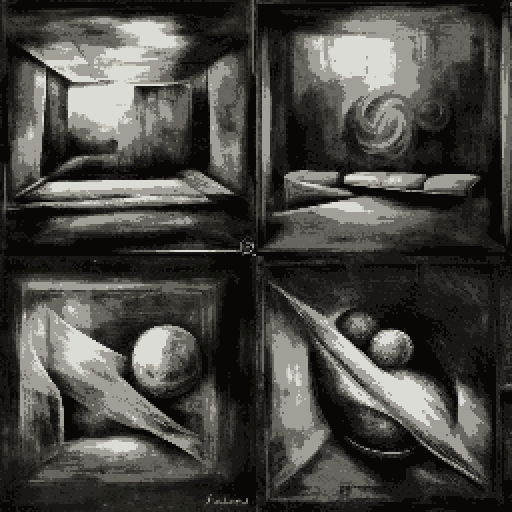

In [281]:
pil_img = Image.open('../raw_data/mj_background.png')
img = pil_img.quantize(colors=32, method=2).resize((256, 256), Image.LANCZOS).resize((512, 512), Image.LANCZOS)
img

In [282]:
img.save('../raw_data/latent_space_background_32bit.png')

In [62]:
# #!mkdir ../raw_data/images_simple

# pil_img = Image.open('../raw_data/latent_space_background_32bit.png')

# img = simplify_image(pil_img, num_colors = 8, size = (128, 128))

# # img.save('../raw_data/latent_space_background_256bit.png'

NameError: name 'img' is not defined

In [21]:
# !mkdir ../raw_data/artist_images_semisimple/

In [22]:
# import os
# from tqdm import tqdm
# for file_name in tqdm(os.listdir("../raw_data/artist_images")):
#     if file_name.endswith('.png'):
#         pil_img = Image.open(f"../raw_data/artist_images/{file_name}")
#         simp_img = simplify_image(pil_img, num_colors = 256, size = (240, 240))
#         border_img = add_border(simp_img, width = 8)
#         border_img.save(f"../raw_data/artist_images_semisimple/{file_name}")

100%|█████████████████████████████████████████| 480/480 [00:30<00:00, 15.62it/s]


### choose less images and reduce the scale of the json